# Blackbird Neural Network Filtering

This notebook explores the use of neural networks to act as an onboard an realtime fast filter instead of the slower Savitzky-Golaz filter currently being used. This would allow for a network to give reasonably accurate state information for some arbitrary controller. It may be faster than current methods.

## Load in Data

First thing is that the library and flight test data need to be imported before any training can be done.

In [1]:
import importlib
import os
import sys
import time
sys.path.append(os.path.abspath('../functions'))

import read_blackbird_dataset as rbd
import dsp
import quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba
import numpy as np
import pandas as pd

from sklearn import model_selection
import tensorflow as tf

In [2]:
# Initial read in
print('Time elapsed breakdown')

t0 = time.time()
test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)
# test_df = rbd.read_blackbird_test('3dFigure8', 'Constant', 5.)
t1 = time.time()
print("\tInitial Flight Data Read in = %f [s]" % (t1 - t0))

rbd.imu_installation_correction(test_df)
t2 = time.time()
print('\tIMU correction = %f [s]' % (t2 - t1))

test_df = rbd.inertial_position_derivatives_estimation(test_df)
t3 = time.time()
print('\tInertial position derivative estimates = %f [s]' % (t3 - t2))

test_df = rbd.gyroscope_derivatives_estimation(test_df)
t4 = time.time()
print('\tGyroscope derivative estimates = %f [s]' % (t4 - t3))

test_df = rbd.consistent_quaternions(test_df)
t5 = time.time()
print('\tConsistent quaternions = %f [s]' % (t5 - t4))

test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
t6 = time.time()
print('\tQuaternion derivate estimates = %f [s]' % (t6 - t5))

test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
t7 = time.time()
print('\tBody rates from quaternion derivatives = %f [s]' % (t7-t6))

test_df = rbd.motor_scaling(test_df)
t8 = time.time()
print('\tRescale motor angular rates = %f [s]' % (t8 - t7))

test_df = rbd.motor_rates(test_df)
t9 = time.time()
print('\tMotor derivates = %f [s]' % (t9 - t8))

test_df = rbd.quaternion_body_acceleration(test_df)
t10 = time.time()
print('\tPut in body frame accelerations = %f' % (t10 - t9))

test_df = rbd.on_ground(test_df)
t11 = time.time()
print('\tBoolean for flying = %f [s]' % (t11 - t10))

print('Total time elapsed = %f' % (t11 - t0))
test_df.info()

Time elapsed breakdown
	Initial Flight Data Read in = 21.981578 [s]
	IMU correction = 0.262040 [s]
	Inertial position derivative estimates = 110.539764 [s]
	Gyroscope derivative estimates = 29.729401 [s]
	Consistent quaternions = 2.410470 [s]
	Quaternion derivate estimates = 145.356665 [s]
	Body rates from quaternion derivatives = 3.749655 [s]
	Rescale motor angular rates = 0.753926 [s]
	Motor derivates = 72.354859 [s]
	Put in body frame accelerations = 14.610816
	Boolean for flying = 60.685925 [s]
Total time elapsed = 462.435100
<class 'pandas.core.frame.DataFrame'>
Int64Index: 702053 entries, 1526617312016142000 to 1526617526742182000
Data columns (total 91 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM2                            39823 non-null   float64
 2   PWM3                            39823 non-null   float64
 3   PWM4   

## Baseline TensorFlow

First model to establish a baseline of Tensorflow and Keras is to estimate the acceleration due to gravity in the quadcopter body frame. This is convenient since this acceleration is for the most part time invariant and the time series of quaternions and the calculated acceleration due to gravity is the same.

In [3]:
# Isolate Input and Output from flight test
qvec = test_df[['qw', 'qx', 'qy', 'qz']].dropna().values
gvec = test_df[['ax_g|B_[m/s2]', 'ay_g|B_[m/s2]', 'az_g|B_[m/s2]']].dropna().values

# Scaling factor to g's from [-1, 1] which represents the range of the Xsens MTi-3 IMU's accelerometer
gsf = 16*9.81  # +/- 16 g range
gvec = gvec/ gsf

In [4]:
# Split up into test and train sets (70-30 split)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    qvec, gvec, test_size=0.30, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54100, 4) (54100, 3)
(23187, 4) (23187, 3)


In [5]:
# Creating a model
inputs = tf.keras.Input(shape=(4,))
x = tf.keras.layers.Dense(3, activation=tf.nn.tanh)(inputs)
x = tf.keras.layers.Dense(2, activation=tf.nn.tanh)(x)
outputs = tf.keras.layers.Dense(3, activation=tf.nn.tanh)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.mse,
    metrics=[tf.keras.metrics.mse],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 15        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.predict(X_train[:10])

array([[ 0.00393485, -0.22797686, -0.38355783],
       [ 0.00401763, -0.2281629 , -0.38373354],
       [ 0.0035752 , -0.2275706 , -0.38343483],
       [ 0.00393482, -0.22754183, -0.38286462],
       [-0.00099038, -0.2139059 , -0.36829057],
       [ 0.00164022, -0.2229733 , -0.37893078],
       [ 0.01194207, -0.23929423, -0.38994798],
       [ 0.00300985, -0.22673175, -0.38292286],
       [ 0.00523006, -0.2316343 , -0.38749504],
       [-0.00091611, -0.21416685, -0.3685994 ]], dtype=float32)

In [7]:
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    verbose=0,
    validation_data=(X_test, y_test)
)

In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
95,3.381799e-07,3.381797e-07,3.024587e-07,3.024590e-07,95
96,3.380532e-07,3.380533e-07,2.761230e-07,2.761229e-07,96
97,3.395280e-07,3.395280e-07,5.347876e-07,5.347876e-07,97
98,3.391376e-07,3.391378e-07,2.336818e-07,2.336818e-07,98
99,3.367817e-07,3.367819e-07,3.791474e-07,3.791475e-07,99


In [9]:
inputs = tf.keras.Input(shape=(4,))
x = tf.keras.layers.Dense(3, activation=tf.nn.tanh)(inputs)
x = tf.keras.layers.Dense(2, activation=tf.nn.tanh)(x)
outputs = tf.keras.layers.Dense(3, activation=tf.nn.tanh)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.mse,
    metrics=[tf.keras.metrics.mse],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 9         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [10]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    validation_data = (X_test, y_test),
    verbose=0,
    callbacks=[early_stop]
)

<IPython.core.display.Javascript object>


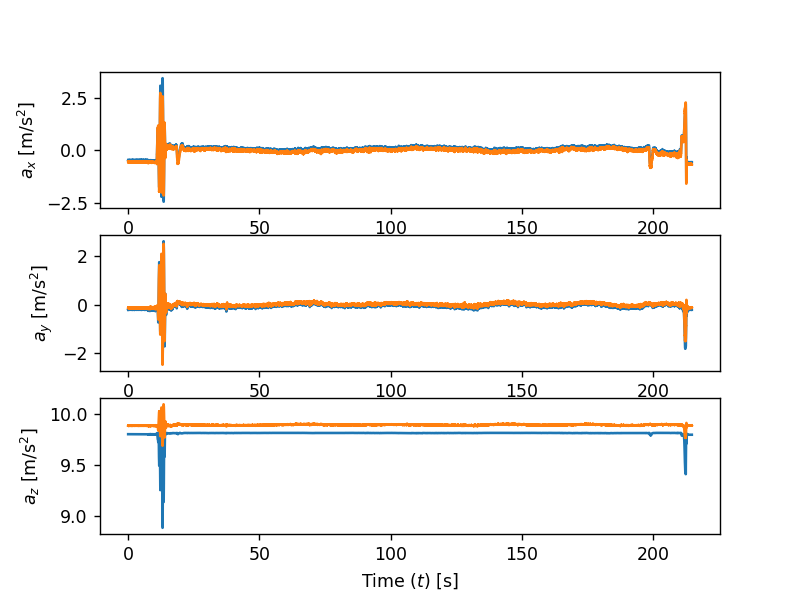

In [11]:
# Showing the acceration over flight test
tvec = test_df[['qw']].dropna().index.values
tvec = (tvec - tvec[0])*(10 ** -9)
tvec = tvec.astype('float')

gvec = test_df[['ax_g|B_[m/s2]', 'ay_g|B_[m/s2]', 'az_g|B_[m/s2]']].dropna().values
gpred = model.predict(qvec)*gsf

fig, ax = plt.subplots(3,1)

ax[0].plot(tvec, gvec[:, 0], label='Known')
ax[0].plot(tvec, gpred[:, 0], label='NN estimated')
ax[1].plot(tvec, gvec[:, 1])
ax[1].plot(tvec, gpred[:, 1])
ax[2].plot(tvec, gvec[:, 2])
ax[2].plot(tvec, gpred[:, 2])

ax[0].set_ylabel('$a_x$ [m/s$^2$]')
ax[1].set_ylabel('$a_y$ [m/s$^2$]')
ax[2].set_ylabel('$a_z$ [m/s$^2$]')
ax[2].set_xlabel('Time ($t$) [s]')

plt.show()

## Derivative Estimation Model

This neural network model is to try and estimate the various derivatives from not readily obtainable from sensors. List of sensors we have are below:

|Sensor | Variable | Frame |
|---:| :---:|:---:|
|Accelerometer|$\dfrac{d^2}{dt^2}\vec{p}$|Relative|
|Gyroscope|$\dfrac{d}{dt}\vec{\theta}$|Relative|
|VICON|$\vec{p}$ and $\vec{\theta}$|Inertial|

Ignoring transforms between the relative and inerital frames and the noise in the measurements, the sets of variables not here are the velocity $\dfrac{d}{dt}\vec{p}$ and rotational acceleration $\dfrac{d^2}{dt^2} \theta$ which are important for the trajectory planning/control algorithms/schemes.

### Velocity Estimation

#### Basic Neural Network

Simpliest esimation is to use a past history of $n$ relative positions so that $\vec{p}[n] = \vec{0}$ and the network is trying to predict $\dfrac{d\vec{p}}{dt}[n]$. An option input to the network is the $n$ relative sample times and this way it is possible to try to test the effects of downsampling so that the network is decently robust and more widely applicable to other vehicle platforms. Scaling the inputs and outputs will be kind of arbitrary. What appears to make the most sense is to set a maximum velocity $V_{\max}$, $n$ samples, and a nominal sampling time $\Delta t$. This form a maximum scalar position bound $p_{\max} = n\Delta t V_\max$ to scale the relative positions. There will be two strategies tested, whether a 1D estimator repeated 3 times is sufficient or if a 3D estimator is better.

In [12]:
# Training and testing a regular 1D
n = 10  # generate n samples for now

# get position values
p_measured = test_df[['px_[m]', 'py_[m]', 'py_[m]']].dropna().values

# Number of points and spacial dimensions
Np = p_measured.shape[0]
Nd = p_measured.shape[1]

X = np.zeros((Nd*(Np - n + 1), n))

# Iterate through dimensions
for i in range(3):
    istart = i*(Np - n)
    istop = istart + Np - n +1
    # Iterate through n points
    for j in range(1, n):
        # I know the p[n] is always zeros but I could poentially use the smoothed value instead
        dp = p_measured[n-j-1:Np-j, i] - p_measured[n-1:, i]
        X[istart:istop, j] = dp

print(X.shape)
print(X[:5, :])

(231834, 10)
[[ 0.0000000e+00 -2.8848650e-05  4.2915300e-06  5.7220500e-06
   1.0442734e-04  7.2717670e-05  2.6464460e-05 -1.4781950e-05
   1.1205670e-05  6.8426130e-05]
 [ 0.0000000e+00  1.6212460e-05 -1.2636190e-05  2.0503990e-05
   2.1934510e-05  1.2063980e-04  8.8930130e-05  4.2676920e-05
   1.4305100e-06  2.7418130e-05]
 [ 0.0000000e+00 -3.5285950e-05 -1.9073490e-05 -4.7922140e-05
  -1.4781960e-05 -1.3351440e-05  8.5353850e-05  5.3644180e-05
   7.3909700e-06 -3.3855440e-05]
 [ 0.0000000e+00  1.7642980e-05 -1.7642970e-05 -1.4305100e-06
  -3.0279160e-05  2.8610200e-06  4.2915400e-06  1.0299683e-04
   7.1287160e-05  2.5033950e-05]
 [ 0.0000000e+00 -1.4781950e-05  2.8610300e-06 -3.2424920e-05
  -1.6212460e-05 -4.5061110e-05 -1.1920930e-05 -1.0490410e-05
   8.8214880e-05  5.6505210e-05]]


In [13]:
# Velocoity estimates
v_est = test_df[['vx_I_[m/s]', 'vy_I_[m/s]', 'vz_I_[m/s]']].dropna().values[n-1:]
y_est = v_est.flatten('F')

<IPython.core.display.Javascript object>


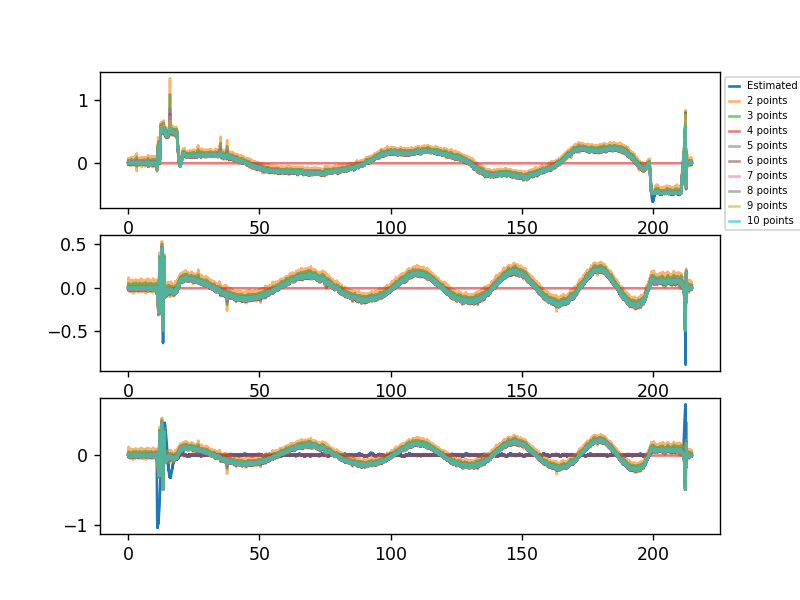

In [14]:
import copy

# Setting vehicle parameter
dt = 1./200.  # Normal 200 Hz update rate
Vmax = 5  # m/s

# Getting a time vector for plotting
tvec = test_df[['qw']].dropna().index.values
tvec = (tvec - tvec[0])*(10 ** -9)
tvec = tvec.astype('float')
tvec = tvec[n-1:]  # Trim off unused front

fig, ax = plt.subplots(3,1)

# plot actual values
ax[0].plot(tvec, v_est[:, 0], label='Estimated')
ax[1].plot(tvec, v_est[:, 1])
ax[2].plot(tvec, v_est[:, 2])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse')
training_histories = []

for ni in range(2, 11):
    inputs = tf.keras.Input(shape=(ni,))
    x = tf.keras.layers.Dense(max(2, int(ni/2)), activation=tf.nn.relu)(inputs)
    x = tf.keras.layers.Dense(max(2, int(ni/4)), activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(1, activation=tf.nn.tanh)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss=['mse'],
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )
    
    y_normed = y_est/Vmax
    X_normed = X[:, :ni]/(Vmax*n*dt)
    
    tf.random.set_seed(42)  # Meaning of life
    hist = model.fit(
        x=copy.deepcopy(X_normed), y=y_normed,
        batch_size=1000,
        epochs=100,
        verbose=0,
        callbacks=[early_stop],
        validation_split=0.3,  # 70-30 train validation split
        shuffle=True,
        validation_freq=1,
    )
    training_histories.append(hist)
    
    y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
    v_pred = y_pred*Vmax
    
    ax[0].plot(tvec, v_pred[:, 0], label=("%i points" % ni), alpha=0.6)
    ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
    ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)
    
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)
plt.show()

<IPython.core.display.Javascript object>


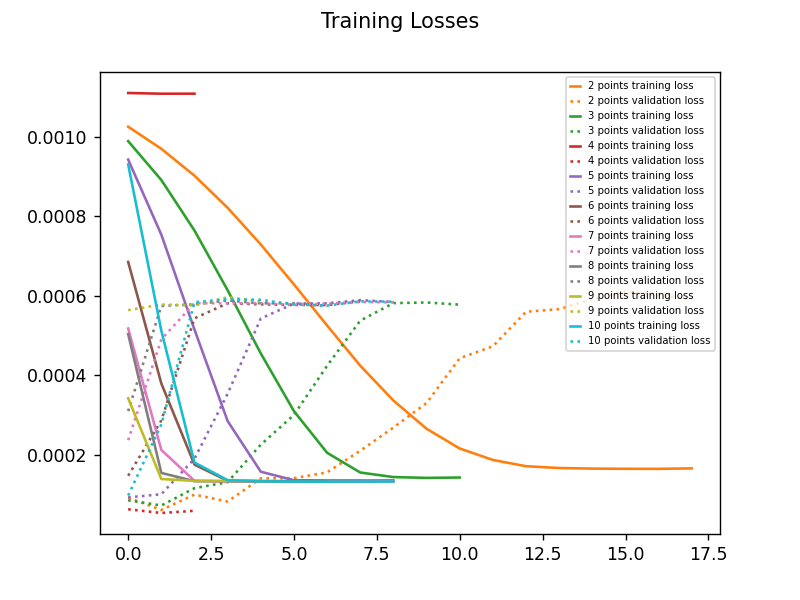

In [15]:
# plot training history
fig, ax_t = plt.subplots(1, 1)

for line, hist in zip(ax[0].get_lines()[1:], training_histories):
    c = line.get_color()
    # Vectors for plotting
    lvec = np.array(hist.history['loss'])
    vlvec = np.array(hist.history['val_loss'])
    epoch_vec = np.array(list(range(lvec.shape[0])))
    
    ax_t.plot(epoch_vec, lvec, color=c, label=(line.get_label() + ' training loss'))
    ax_t.plot(epoch_vec, vlvec, color=c, linestyle=':', label=(line.get_label() + ' validation loss'))

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
plt.show()

In [16]:
# Training and testing a regular 1D
n = 10  # generate n samples for now

# get position values
p_measured = test_df[['px_[m]', 'py_[m]', 'py_[m]']].dropna().values

# Number of points and spacial dimensions
Np = p_measured.shape[0]
Nd = p_measured.shape[1]

X = np.zeros((Np - n + 1, Nd, n))

# Iterate through dimensions
for i in range(3):
    istart = i*(Np - n)
    istop = istart + Np - n +1
    # Iterate through n points
    for j in range(1, n):
        # I know the p[n] is always zeros but I could poentially use the smoothed value instead
        dp = p_measured[n-j-1:Np-j, i] - p_measured[n-1:, i]
        X[:, i, j] = dp

print(X.shape)
print(X[:2, :, :])

(77278, 3, 10)
[[[ 0.0000000e+00 -2.8848650e-05  4.2915300e-06  5.7220500e-06
    1.0442734e-04  7.2717670e-05  2.6464460e-05 -1.4781950e-05
    1.1205670e-05  6.8426130e-05]
  [ 0.0000000e+00 -2.6732683e-05  6.1959028e-05  5.4717064e-05
    5.3286553e-05 -9.2446804e-05 -6.7144632e-05 -2.1457670e-06
    3.2186508e-05 -5.5462122e-05]
  [ 0.0000000e+00 -2.6732683e-05  6.1959028e-05  5.4717064e-05
    5.3286553e-05 -9.2446804e-05 -6.7144632e-05 -2.1457670e-06
    3.2186508e-05 -5.5462122e-05]]

 [[ 0.0000000e+00  1.6212460e-05 -1.2636190e-05  2.0503990e-05
    2.1934510e-05  1.2063980e-04  8.8930130e-05  4.2676920e-05
    1.4305100e-06  2.7418130e-05]
  [ 0.0000000e+00 -1.2397766e-05 -3.9130449e-05  4.9561262e-05
    4.2319298e-05  4.0888787e-05 -1.0484457e-04 -7.9542398e-05
   -1.4543533e-05  1.9788742e-05]
  [ 0.0000000e+00 -1.2397766e-05 -3.9130449e-05  4.9561262e-05
    4.2319298e-05  4.0888787e-05 -1.0484457e-04 -7.9542398e-05
   -1.4543533e-05  1.9788742e-05]]]


In [17]:
# 3D Velocoity estimates
v_est = test_df[['vx_I_[m/s]', 'vy_I_[m/s]', 'vz_I_[m/s]']].dropna().values[n-1:]
y_est = v_est

<IPython.core.display.Javascript object>


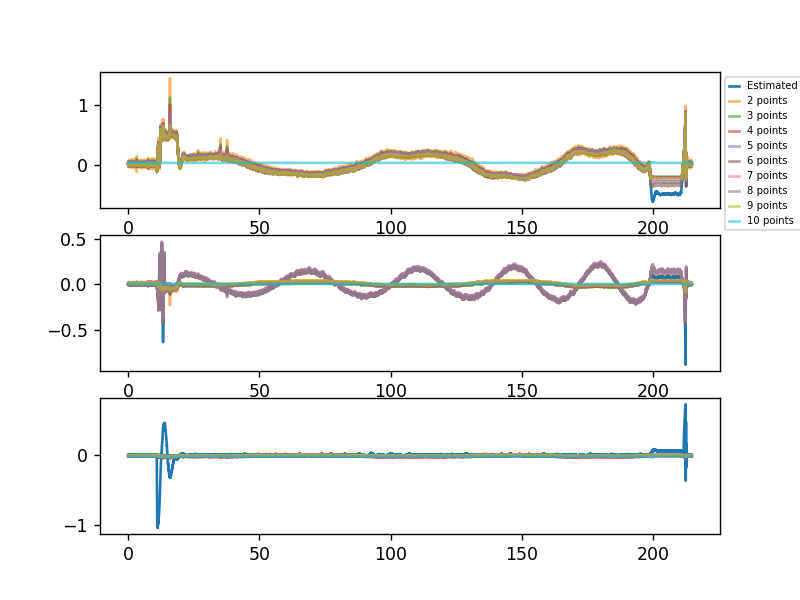

In [18]:
import copy

# Setting vehicle parameter
dt = 1./200.  # Normal 200 Hz update rate
Vmax = 5  # m/s

# Getting a time vector for plotting
tvec = test_df[['qw']].dropna().index.values
tvec = (tvec - tvec[0])*(10 ** -9)
tvec = tvec.astype('float')
tvec = tvec[n-1:]  # Trim off unused front

fig, ax = plt.subplots(3,1)

# plot actual values
ax[0].plot(tvec, v_est[:, 0], label='Estimated')
ax[1].plot(tvec, v_est[:, 1])
ax[2].plot(tvec, v_est[:, 2])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse')
training_histories = []

for ni in range(2, 11):
    y_normed = y_est/Vmax
    X_normed = X[:, :, :ni]/(Vmax*n*dt)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_normed.shape[1:]))
    model.add(tf.keras.layers.Dense(max(2, int(ni/2)), activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(max(2, int(ni/4)), activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(Nd, activation=tf.nn.tanh))
    
    model.compile(
        optimizer='rmsprop',
        loss=['mse'],
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )
    
    tf.random.set_seed(42)  # Meaning of life
    hist = model.fit(
        x=copy.deepcopy(X_normed), y=y_normed,
        batch_size=1000,
        epochs=100,
        verbose=0,
        callbacks=[early_stop],
        validation_split=0.3,  # 70-30 train validation split
        shuffle=True,
        validation_freq=1,
    )
    training_histories.append(hist)
    
    y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
    v_pred = y_pred*Vmax
    
    ax[0].plot(tvec, v_pred[:, 0], label=("%i points" % ni), alpha=0.6)
    ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
    ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)
    
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)
plt.show()

<IPython.core.display.Javascript object>


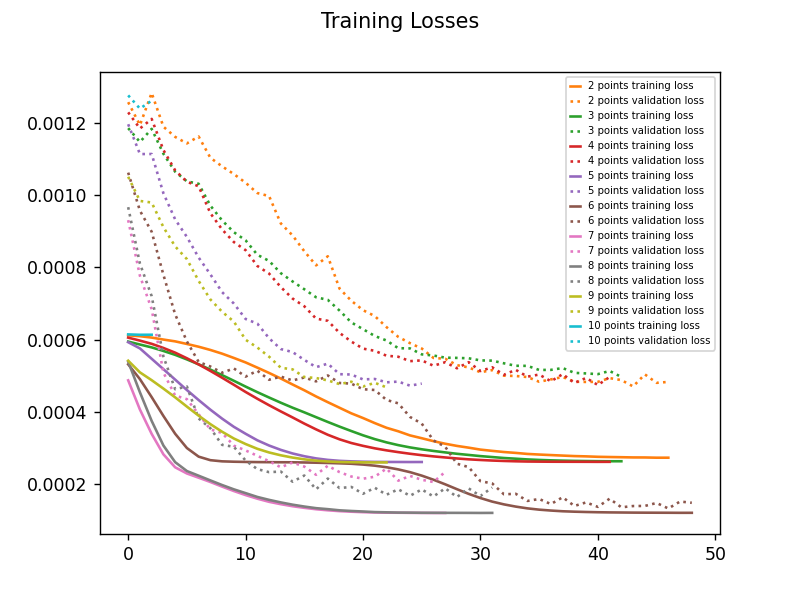

In [19]:
# plot training history
fig, ax_t = plt.subplots(1, 1)

for line, hist in zip(ax[0].get_lines()[1:], training_histories):
    c = line.get_color()
    # Vectors for plotting
    lvec = np.array(hist.history['loss'])
    vlvec = np.array(hist.history['val_loss'])
    epoch_vec = np.array(list(range(lvec.shape[0])))
    
    ax_t.plot(epoch_vec, lvec, color=c, label=(line.get_label() + ' training loss'))
    ax_t.plot(epoch_vec, vlvec, color=c, linestyle=':', label=(line.get_label() + ' validation loss'))

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
plt.show()

It appears that dealing with vectors has better results for estimating derivatives although vectors generally need more epochs for training by about 3 times as much. This is likely that 1 dimensional estimates had 3 times as much data as the 3D vector case.

### Different Training weights

Trying the above work with a training weight scheme to attempt to fit it close to the extremes during take off and landing. The neural network being used is the 6 point estimator to which was the best trained network. The idea of the weights is train it as originally and than use the errors to do another fit. Weight scheme is $ w(n) = e^{\mathit{e}_n^2} $ where $n$ is the index for weights $w$ with the corresponding error $\mathit{e}_n$.

<IPython.core.display.Javascript object>


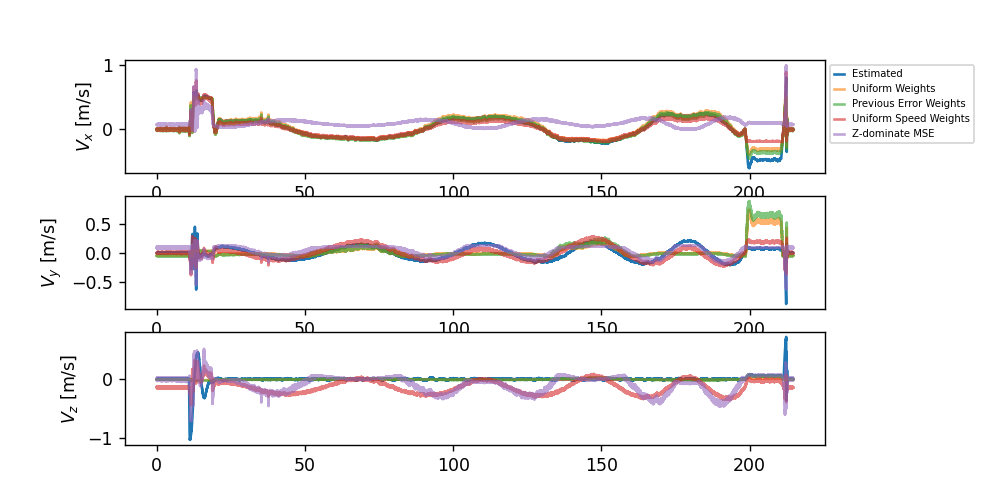

  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [20]:
# Setting vehicle parameter
dt = 1./200.  # Normal 200 Hz update rate
Vmax = 5  # m/s

fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 4)

for sax in ax:
    bbox = sax.get_position()
    p0 = bbox.p0
    p1 = bbox.p1
    sax.set_position([p0[0], p0[1], 0.7, p1[1] - p0[1]])

# plot actual values
ax[0].plot(tvec, v_est[:, 0], label='Estimated')
ax[1].plot(tvec, v_est[:, 1])
ax[2].plot(tvec, v_est[:, 2])

ax[0].set_ylabel('$V_x$ [m/s]')
ax[1].set_ylabel('$V_y$ [m/s]')
ax[2].set_ylabel('$V_z$ [m/s]')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse')
training_histories = []

# Creating first model
ni = 6
y_normed = y_est/Vmax
X_normed = X[:, :, :ni]/(Vmax*n*dt)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X_normed.shape[1:]))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Nd, activation=tf.nn.tanh))

# Compiled model
model.compile(
    optimizer='rmsprop',
    loss=['mse'],
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)

# First training
tf.random.set_seed(42)  # Meaning of life
hist = model.fit(
    x=X_normed, y=y_normed,
    batch_size=1000,
    epochs=100,
    verbose=0,
    callbacks=[early_stop],
    validation_split=0.3,  # 70-30 train validation split
    shuffle=True,
    validation_freq=1,
)
training_histories.append(hist)

y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
v_pred = y_pred*Vmax

# Plotting
ax[0].plot(tvec, v_pred[:, 0], label=("Uniform Weights"), alpha=0.6)
ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)
    
# Calculating error weights
weights = np.exp(np.sum((v_est - v_pred) ** 2, axis=1)).flatten()

# Second training
tf.random.set_seed(42)  # Meaning of life
hist = model.fit(
    x=X_normed, y=y_normed,
    batch_size=1000,
    epochs=100,
    verbose=0,
    validation_split=0.3,  # 70-30 train validation split
    shuffle=True,
    sample_weight=weights,
    initial_epoch=0,
    validation_freq=1,
)
training_histories.append(hist)

y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
v_pred = y_pred*Vmax

# Plotting
ax[0].plot(tvec, v_pred[:, 0], label=("Previous Error Weights"), alpha=0.6)
ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)

# Making the model again
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X_normed.shape[1:]))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Nd, activation=tf.nn.tanh))

# Compiled model
model.compile(
    optimizer='rmsprop',
    loss=['mse'],
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)

weights = np.sum(v_est ** 2, axis=1).flatten()

# Third training
tf.random.set_seed(42)  # Meaning of life
hist = model.fit(
    x=X_normed, y=y_normed,
    batch_size=1000,
    epochs=100,
    verbose=0,
    validation_split=0.3,  # 70-30 train validation split
    shuffle=True,
    sample_weight=weights,
    initial_epoch=0,
    validation_freq=1,
)
training_histories.append(hist)

y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
v_pred = y_pred*Vmax

# Plotting
ax[0].plot(tvec, v_pred[:, 0], label=("Uniform Speed Weights"), alpha=0.6)
ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)

# Making the model again
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X_normed.shape[1:]))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Nd, activation=tf.nn.tanh))

# Custom Loss function
def wL2(y_actual, y_predicted):
    e2 = tf.keras.backend.square(y_actual - y_predicted)  # squared error
    return (e2[:,0] + e2[:,1] + 100*e2[:,2])

# Compiled model
model.compile(
    optimizer='rmsprop',
    loss=[wL2],
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)


# Fourth training
tf.random.set_seed(42)  # Meaning of life
hist = model.fit(
    x=X_normed, y=y_normed,
    batch_size=1000,
    epochs=100,
    verbose=0,
    validation_split=0.3,  # 70-30 train validation split
    shuffle=True,
    sample_weight=weights,
    initial_epoch=0,
    validation_freq=1,
)
training_histories.append(hist)

y_pred = model.predict(X_normed).reshape((Np-n+1, 3), order='F')
v_pred = y_pred*Vmax

# Plotting
ax[0].plot(tvec, v_pred[:, 0], label=("Z-dominate MSE"), alpha=0.6)
ax[1].plot(tvec, v_pred[:, 1], alpha=0.6)
ax[2].plot(tvec, v_pred[:, 2], alpha=0.6)


ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)
plt.show()

<IPython.core.display.Javascript object>


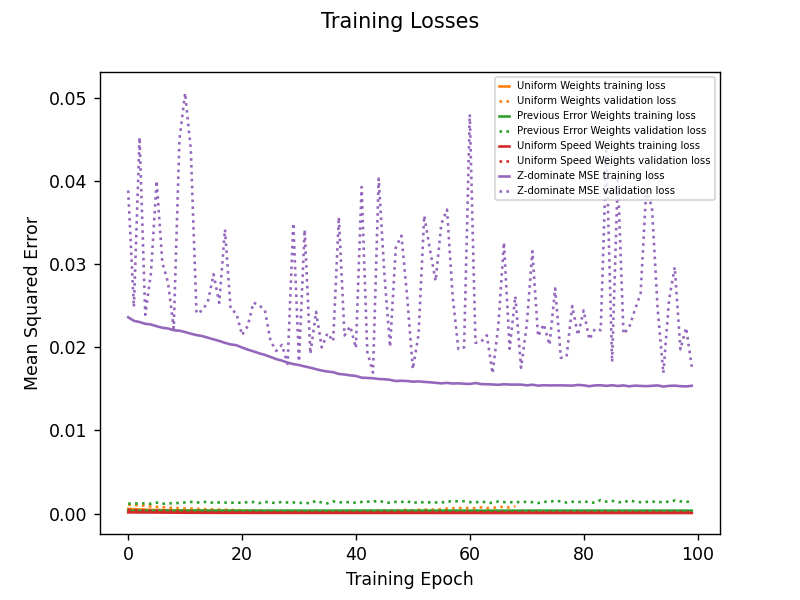

In [21]:
# plot training history
fig, ax_t = plt.subplots(1, 1)

for line, hist in zip(ax[0].get_lines()[1:], training_histories):
    c = line.get_color()
    # Vectors for plotting
    lvec = np.array(hist.history['loss'])
    vlvec = np.array(hist.history['val_loss'])
    epoch_vec = np.array(list(range(lvec.shape[0])))
    
    ax_t.plot(epoch_vec, lvec, color=c, label=(line.get_label() + ' training loss'))
    ax_t.plot(epoch_vec, vlvec, color=c, linestyle=':', label=(line.get_label() + ' validation loss'))

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)

ax_t.set_ylabel('Mean Squared Error')
ax_t.set_xlabel('Training Epoch')

plt.show()